In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
import gget
import sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
import xgi

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

In [2]:
# structure the features
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/1D_features/"
resolution = "1000000"

features = []
for f in os.listdir(dpath):
    if not resolution in f:
        continue
    dtype = f.split("_")[0]
    fpath = f"{dpath}{f}"
    fdf = pd.read_parquet(fpath)
    fdf = fdf.set_index('index')
    fdf.columns = [f"{dtype}_{x}" for x in fdf.columns]
    features.append(fdf)

features = pd.concat(features, axis=1)
features = features.reset_index(names='bin')
features = features.sort_index()

features = features.set_index('bin')
print(f"{features.shape}")
features.head()

(196, 12)


,ATAC_4DNFIPVAKPXA,ATAC_4DNFIXT1TVT4,ATAC_4DNFI3ARZKH6,CTCF_4DNFIFFXFV82,H3K27me3_4DNFI7UN2C36,RNA_4DNFI12AUKQS,RNA_4DNFIFVPB94O,RNA_4DNFIUW8CG2I,RNA_4DNFIXOTRTRM,RNA_4DNFI4XVSIFH,RNA_4DNFIW5IZKYG,H3K27ac_4DNFIXE23VC7
bin,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,349028.179007,385290.962857,524069.942308,336653.558649,582219.866429,912.626982,350.927492,966.238699,310.774258,1228.049374,894.509115,227477.304170
4,531276.036840,585791.846341,680721.152379,571927.043253,712191.960070,13279.962377,4700.454225,14531.082911,5369.831270,70671.565333,52421.834231,689715.321583


In [3]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/rna/expression.parquet"
gdf = pd.read_parquet(fpath)

resolution = 1000000

gdf = gdf[gdf['Chromosome'] == "1"]
gdf = gdf[gdf['gene_biotype'] == "protein_coding"]
gdf['bin'] = gdf['midpoint'].apply(lambda x: ut.bin_loci(x, resolution))

renamer = {
    '4DNFI8CSCJWM_TPM' :  'TPM_4DNFI8CSCJWM' , 
    '4DNFICXJQ3PA_TPM' :  'TPM_4DNFICXJQ3PA' , 
    '4DNFI3YYNDKI_TPM' :  'TPM_4DNFI3YYNDKI' , 
    '4DNFIPYGE7JR_TPM' :  'TPM_4DNFIPYGE7JR' , 
    '4DNFIYTCHMIZ_TPM' :  'TPM_4DNFIYTCHMIZ' , 
    '4DNFIC269AEU_TPM' :  'TPM_4DNFIC269AEU' ,
}

gdf = gdf.rename(columns=renamer)

# agregate over bins

edf = gdf.groupby('bin').agg(
    GENE_COUNT = ('gene_name', 'count'),
    TF_COUNT = ('is_tf', 'sum'),
    TPM_4DNFI8CSCJWM = ('TPM_4DNFI8CSCJWM', 'mean'), 
    TPM_4DNFICXJQ3PA = ('TPM_4DNFICXJQ3PA', 'mean'), 
    TPM_4DNFI3YYNDKI = ('TPM_4DNFI3YYNDKI', 'mean'), 
    TPM_4DNFIPYGE7JR = ('TPM_4DNFIPYGE7JR', 'mean'), 
    TPM_4DNFIYTCHMIZ = ('TPM_4DNFIYTCHMIZ', 'mean'), 
    TPM_4DNFIC269AEU = ('TPM_4DNFIC269AEU', 'mean'), 
).reindex(list(range(3, 196))).fillna(0)

print(f"{edf.shape=}")
edf.head()

edf.shape=(193, 8)


,GENE_COUNT,TF_COUNT,TPM_4DNFI8CSCJWM,TPM_4DNFICXJQ3PA,TPM_4DNFI3YYNDKI,TPM_4DNFIPYGE7JR,TPM_4DNFIYTCHMIZ,TPM_4DNFIC269AEU
bin,,,,,,,,
3,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
4,1.0,0.0,0.000000,0.020000,0.000000,0.000,0.000000,0.020000
5,6.0,1.0,6.205000,53.246667,5.645000,5.645,6.205000,53.248333
6,4.0,0.0,1.770000,8.250000,1.300000,1.300,1.770000,8.247500
7,3.0,0.0,2.496667,3.813333,2.176667,2.170,2.496667,3.810000


X.shape=(193, 18)


Text(436.2664141414141, 0.5, '')

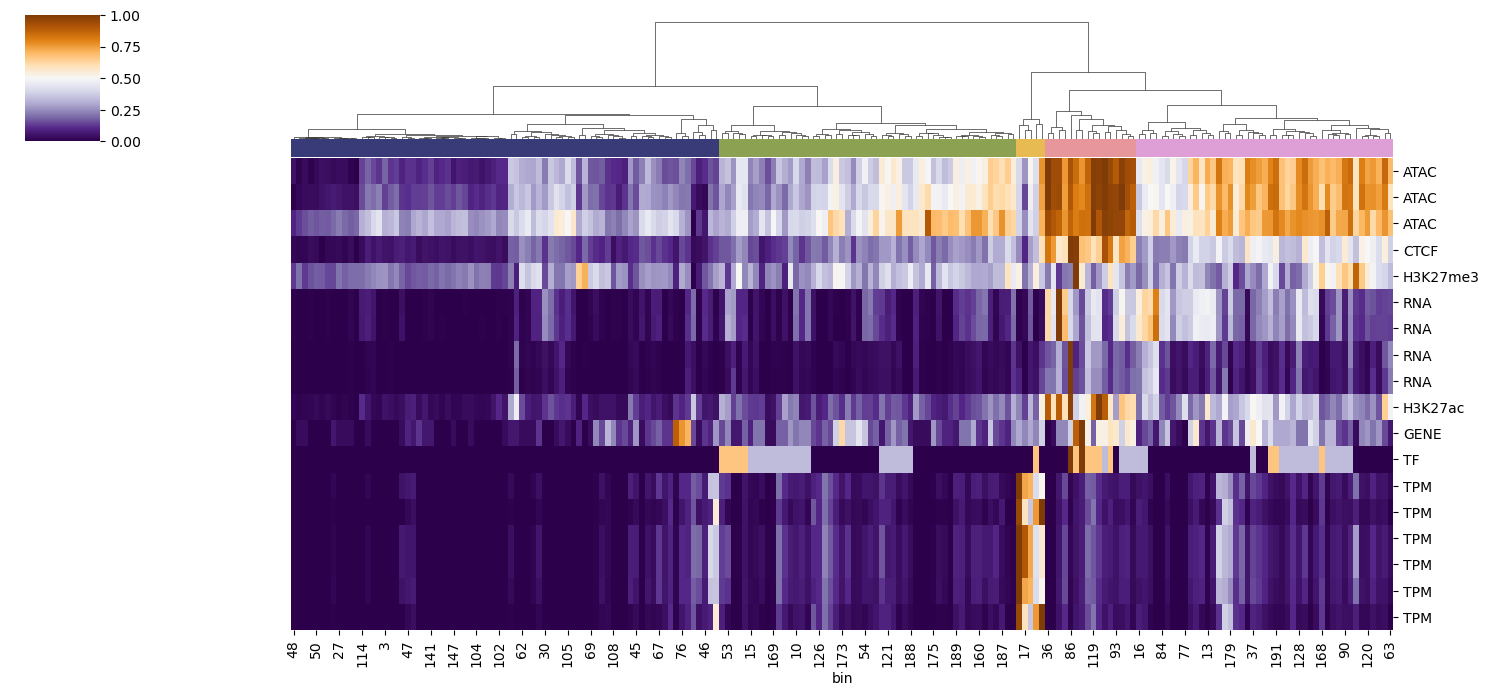

In [19]:
columns = [
    'ATAC_4DNFIPVAKPXA',
    'ATAC_4DNFIXT1TVT4', 
    'ATAC_4DNFI3ARZKH6',
    'CTCF_4DNFIFFXFV82', 
    'H3K27me3_4DNFI7UN2C36', 
    # 'RNA_4DNFI12AUKQS',
    # 'RNA_4DNFIUW8CG2I', 
    'RNA_4DNFIFVPB94O', 
    'RNA_4DNFIXOTRTRM',
    'RNA_4DNFI4XVSIFH', 
    'RNA_4DNFIW5IZKYG', 
    'H3K27ac_4DNFIXE23VC7',
]

X = features[columns]
X = X[X.index > 2]

X = pd.merge(X, edf, how='left', 
            left_index=True,
            right_index=True)

print(f"{X.shape=}")


scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

new_col_names = [x.split("_")[0] for x in X.columns]

X_scaled = pd.DataFrame(X_scaled, columns=new_col_names, index=X.index)
X_scaled = X_scaled.fillna(0)

Z = linkage(X_scaled, method='ward')

max_d = 3

clusters = fcluster(Z, max_d, criterion='distance')
row_colors = clusters
row_colors = plt2.floats_to_colors(row_colors, colormap='tab20b')

sns.clustermap(data=X_scaled.T,
               standard_scale=0,
               col_colors=row_colors,
               col_linkage=Z,
               figsize=(15, 7),
               vmin=0,
               vmax=1,
               cmap='PuOr_r',
               row_cluster=False)

plt.ylabel("")

In [29]:
for cluster in np.unique(clusters):
    print(f"\n====== {cluster=} ======")
    cdf = X[clusters == cluster]
    
    tpm = [x for x in cdf.columns if "TPM" in x]
    rna = [x for x in cdf.columns if "RNA" in x]
    
    print(cdf[tpm].mean())
    print()
    print(cdf[rna].mean())


====== cluster=1 ======
TPM_4DNFI8CSCJWM    0.906027
TPM_4DNFICXJQ3PA    8.037847
TPM_4DNFI3YYNDKI    0.882211
TPM_4DNFIPYGE7JR    0.882277
TPM_4DNFIYTCHMIZ    0.906187
TPM_4DNFIC269AEU    8.037995
dtype: float64

RNA_4DNFIFVPB94O    1827.471587
RNA_4DNFIXOTRTRM    1906.631191
RNA_4DNFI4XVSIFH    9122.509775
RNA_4DNFIW5IZKYG    7483.960273
dtype: float64

====== cluster=2 ======
TPM_4DNFI8CSCJWM     1.794352
TPM_4DNFICXJQ3PA    16.782117
TPM_4DNFI3YYNDKI     1.781214
TPM_4DNFIPYGE7JR     1.781267
TPM_4DNFIYTCHMIZ     1.794170
TPM_4DNFIC269AEU    16.782082
dtype: float64

RNA_4DNFIFVPB94O     4452.589935
RNA_4DNFIXOTRTRM     4614.775949
RNA_4DNFI4XVSIFH    20633.310669
RNA_4DNFIW5IZKYG    17819.499027
dtype: float64

====== cluster=3 ======
TPM_4DNFI8CSCJWM     21.212250
TPM_4DNFICXJQ3PA    306.376481
TPM_4DNFI3YYNDKI     20.640512
TPM_4DNFIPYGE7JR     20.640312
TPM_4DNFIYTCHMIZ     21.213258
TPM_4DNFIC269AEU    306.376242
dtype: float64

RNA_4DNFIFVPB94O     2680.805663
RNA_4DNFIXOTRT